In [40]:
import numpy as np
from numpy.linalg import inv
import sympy as sp
import pandas as pd
import math as m
from sympy import collect, simplify, expand, fraction, latex, diff, cancel, nsimplify
from IPython.display import display, Markdown, Math
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]

In [41]:
theta, theta_d, I, E_bar, w, w_dot = sp.symbols("\\theta \\theta_d I \\bar{E} \omega \dot{\omega}")
e_theta, e_w, e_I = sp.symbols("e_{\\theta} e_{\omega} e_{I} ")
# e_theta_k, e_w_k, e_I_k = sp.symbols("e_{\\theta_{k}} e_{\omega_{k}} e_{I_{k}}")
e_theta_dot, e_omega_dot, e_I_dot = sp.symbols("\dot{e_{\\theta}} \dot{e_{\omega}} \dot{e_{I}}")
J, D, M, g, L, N1, N2, Kt = sp.symbols("J D M g L N_1 N_2 K_t") 
La, Ra, Kb, u = sp.symbols("L_a R_a K_b u")
Ja, Da, DL = sp.symbols("J_a D_a D_L")
delta = sp.Symbol("\Delta")

# Problem 1

## part 1

In [42]:
M_val = 5
L_val = 1
Ra_val = 10
La_val = 0.1
g_val = 9.8
Kt_val = 11
Kb_val = 6.36
DL_val = 1
Da_val = 0.1
Ja_val = 2
N1_val = 15
N2_val = 45
theta_d_val = np.pi/6
Ts = 0.01

J_val = Ja_val + (N1_val/N2_val)**2*M_val*L_val**2
D_val = Da_val + (N1_val/N2_val)**2*DL_val
E_bar = Ra_val*g_val*N1_val/(Kt_val*L_val*N2_val)*np.sin(N1_val/N2_val*theta_d_val)

lst_subs = [(M,M_val), (L,L_val), (Ra,Ra_val), (La,La_val), (g,g_val), (Kt,Kt_val), (Kb,Kb_val), 
            (D,D_val), (J,J_val), (N1,N1_val), (N2,N2_val), 
            (theta_d, theta_d_val), (delta, Ts)]

# eq 3a
org_3a = w
dot_e_theta = e_w
e_theta_k_1 = e_theta + delta*dot_e_theta
e_theta_k_1_subd = e_theta_k_1.subs(lst_subs)
e_theta_k_1_func = sp.lambdify([e_theta, e_w], e_theta_k_1_subd)

# eq 3b
org_3b = sp.Eq(J*w_dot + D*w + M*g*L*N1/N2*(sp.sin(N1/N2*(e_theta + theta_d)) - sp.sin(N1/N2*theta_d)), Kt*e_I)
dot_e_w = sp.solve(org_3b, w_dot)[0].subs(w, e_w)
e_w_k_1 = e_w + delta*dot_e_w
e_w_k_1_subd = e_w_k_1.subs(lst_subs)
e_w_k_1_func = sp.lambdify([e_theta, e_w, e_I, D, J], e_w_k_1_subd)

# eq 3c
org_3c = sp.Eq(La*e_I_dot + Ra*e_I + Kb*w, u)
dot_e_I = sp.solve(org_3c, e_I_dot)[0].subs(w, e_w)
e_I_k_1 = e_I+ delta*dot_e_I
e_I_k_1_subd = e_I_k_1.subs(lst_subs)
e_I_k_1_func = sp.lambdify([e_w, u], e_I_k_1_subd)
e_I_k_1_coeffs = sp.Poly(e_I_k_1, u).coeffs()

# g_xk = sp.Matrix([[0], [0], [e_I_k_1_coeffs[0]*u]])
g_xk = sp.Matrix([[0], [0], [e_I_k_1_coeffs[0]]])
f_xk = sp.Matrix([[e_theta_k_1], [e_w_k_1], [e_I_k_1_coeffs[1]]])

# u is used as a temporary var. makes turning into np array easier
g_xk_func = sp.lambdify([u], g_xk.subs(lst_subs)*u) 
g_xk_subd = g_xk_func(1)

f_xk_func = sp.lambdify([e_theta, e_w, e_I], f_xk.subs(lst_subs))


In [43]:
u

u

$e_{\theta_{k+1}} = \;${{e_theta_k_1}}

$e_{\omega_{k+1}} = \;${{e_w_k_1}}

$e_{I_{k+1}} = \;${{e_I_k_1}}

$f(\cdot) =\;$ {{f_xk}}

$g(\cdot) =\;$ {{g_xk}}

In [57]:
W0 = np.array([6, 8, 0, 9, 5, 0, 4, 1, 5]).reshape(-1,1)
W0

array([[6],
       [8],
       [0],
       [9],
       [5],
       [0],
       [4],
       [1],
       [5]])

## part 2

In [44]:
NL = 9
gamma = 0.9
alpha = 2

theta0 = 0
w0 = 0
I0 = 0

e_theta0 = theta0 - theta_d_val
e_w0 = w0
e_I0 = I0 - E_bar/Ra_val

R = 0.05
q = np.array([[1, 0, 0], 
            [0, 1, 0],
             [0, 0, 1]])

# W0 = np.random.randint(0,10,(1, NL)).T
W0 = np.array([6, 8, 0, 9, 5, 0, 4, 1, 5])
W = [W0]

xk = [np.array([e_theta0, e_w0, e_I0]).reshape(-1,1)]


phi = sp.Matrix([[e_theta, e_w, e_I, 
                 e_theta*e_w, e_theta*e_I, e_w*e_I, 
                 e_theta**2, e_w**2, e_I**2]])

del_phi = sp.Matrix([[diff(phi, e_theta)], [diff(phi, e_w)], [diff(phi, e_I)]])

phi_func = sp.lambdify([e_theta, e_w, e_I], phi)
del_phi_func = sp.lambdify([e_theta, e_w, e_I], del_phi)

lst_phi = [phi_func(*xk[-1].T.tolist()[0])]
lst_u = [float((-gamma/(2*R)*g_xk_subd.T@del_phi_func(*xk[-1].T.tolist()[0])@W[-1]).reshape(()))]

ValueError: x and y must have same first dimension, but have shapes (1001,) and (2001,)

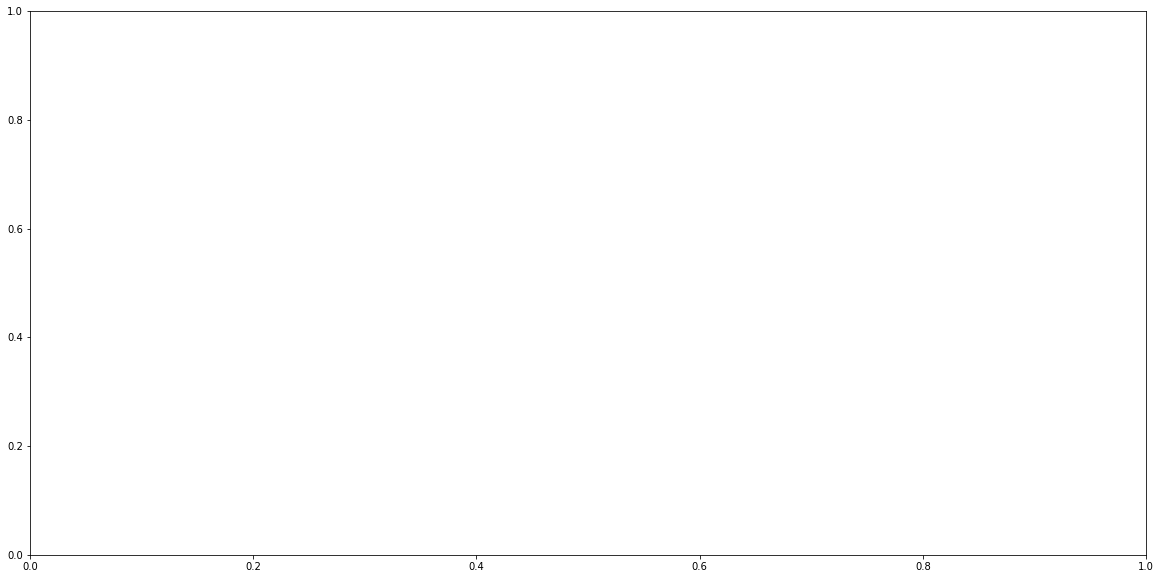

In [45]:
stop_time = 20 # in seconds
cycles = int(stop_time//Ts)
cnt_limit = 1000
eps = 1e-3

t = [0]
k = 0
Wji = 0
while (k < cycles):
#     print(cnt)
#     input("halt")
    Wj_idx = k
    k+=1
    t.append(k*Ts)
    
    Phi = lst_phi[-1].T # phi(x_k) (column vec)
    
    xk.append(f_xk_func(*xk[-1].T.tolist()[0]) + g_xk_subd*lst_u[-1])
    
    lst_phi.append(phi_func(*xk[-1].T.tolist()[0]))
    
    rk = (xk[-2].T@q@xk[-2]).reshape(()) + R*lst_u[-1]**2 + gamma*lst_phi[-1]@W[-1]
    
    cnt = 0
    while ((abs(Wji - W[-1]) < eps).all() | cnt < cnt_limit):
#         print("\n")
#         print(f" W[-1]: {W[-1]}")
#         print(f" Wji: {Wji}")
#         print(f"Phi: {Phi}")
#         input("halt")
        Wji = W[-1]
        try:
            W.append(Wji - alpha*Phi*(Phi.T@Wji - rk))
        except RuntimeWarning:
            print("hit")
            print(cnt)
        xk.append(f_xk_func(*xk[-1].T.tolist()[0]) + g_xk_subd*lst_u[-1]) # Measurment
        k+=1
        t.append(k*Ts)
        lst_u.append(float((-gamma/(2*R)*g_xk_subd.T@del_phi_func(*xk[-1].T.tolist()[0])@W[Wj_idx]).reshape(())))
        Phi = lst_phi[-1].T # phi(x_k) (column vec)
        lst_phi.append(phi_func(*xk[-1].T.tolist()[0]))
        rk = (xk[-2].T@q@xk[-2]).reshape(()) + R*lst_u[-1]**2 + gamma*lst_phi[-1]@W[Wj_idx]
        cnt+=1
        
    lst_u.append(float((-gamma/(2*R)*g_xk_subd.T@del_phi_func(*xk[-1].T.tolist()[0])@W[-1]).reshape(())))
    
    
for j in range(NL):
    plt.plot(t[0:2001], [float((W[i][j]).reshape(())) for i in range(len(W))])
    
plt.show()
    

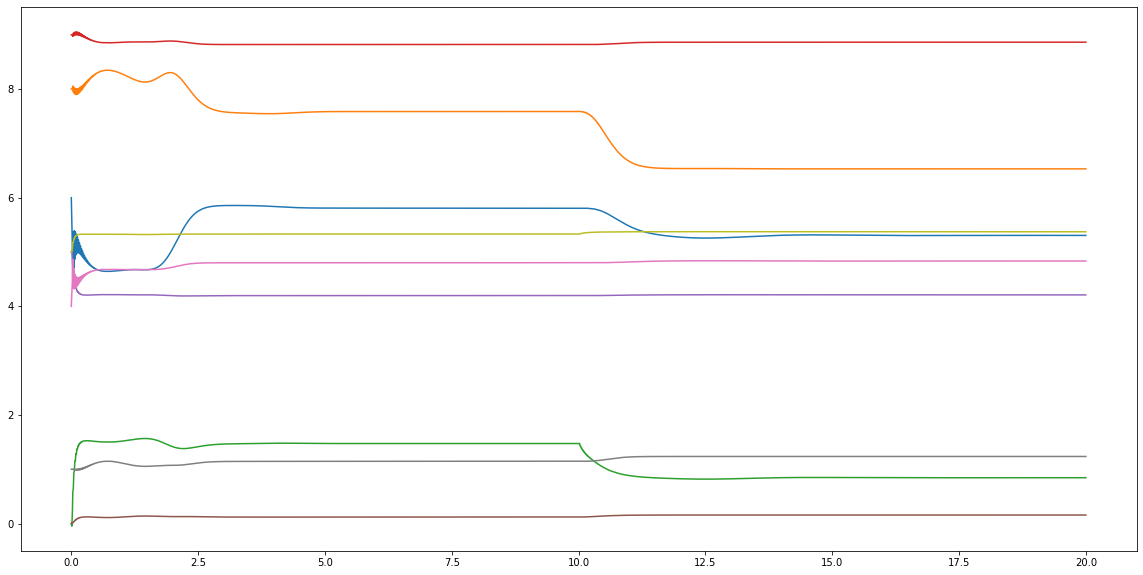

In [50]:
for j in range(NL):
    plt.plot(t[0:2001], [float((W[i][j]).reshape(())) for i in range(len(W))])
    
plt.show()

In [51]:
W[0]

array([[6],
       [8],
       [0],
       [9],
       [5],
       [0],
       [4],
       [1],
       [5]])

In [ ]:
np.shape(W)
len(t[0:1001])

In [ ]:
display(xk[-1])
display((abs(xk[-1]) < 1e-3).all() | True)

In [ ]:
R*lst_u[-1]**2

In [ ]:
(xk[-1].T@q@xk[-1]).reshape(()) + R*lst_u[-1]**2

In [ ]:
f_xk_func(*xk[-1].tolist()[0])